# Content and Objectives

- Show effects of convolutional coding 
- BPSK symbols are being transmitted with and without coding and BERs are compared

- NOTE: The underlying convolutional coding class is slightly extensive and contains about 280 lines of codes. For understanding principles the according cell may be omitted since the identifiers in upcoming cells should (hopefully) be chosen in an understandable manner.

# Importing

In [1]:
import numpy as np
from scipy import stats, special
import itertools

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

# Convolutional-Coding Class

NOTE: If you are only interested in communication theoretical principles and/or results, the following cell may be ignored

In [3]:
# class for convolutional-coding  
class c_Convolutional_code():
    '''
    Class for convolutional coding and decoding. 
    
    - Only single bit inputs allowed (no bit groups).
    - Only BPSK as modulation type in main simulation.
    
    All vectors are lists, matrix G describing feed-forward coefficients is list of lists
    
    NOTE:
    - keys are tuples describing current state
    - predecessor has shape: current state (tuple) : [ input (bit), past state (tuple), output (bits) ] (as list)
    - survivor (Viterbi) has shape: ( time, state) (tuples) : [ weight, history (list) ]
    - states has shape: state (tuple): [ [ 0, next state (tuple), output], [ 1, next_state (tuple), output ] ] (as list of lists)
    '''

    # initialize by defining G
    def __init__( self, G, packet_size ):
        '''
        initialization
        
        OUT: G, r, numb_cells, packet_size, free distance (for theoretical BER), states and state transitions
        '''

        len_first = len ( G[0] )
        assert all( len( g ) == len_first for g in G ), 'All feed-forward vectors should possess the same length!'
        
        self.G = G  

        self.n = len( self.G )        
        self.numb_cells = len( G[0] )
        
        self.packet_size = int( packet_size )
        
        # free distance out of [Friedrichs95, S.258] 
        self.d_f = np.sum( [ np.sum( g ) for g in self.G ] )
        
        # states and transitions
        self.states = self._get_states()
        
        # dict for predecessor
        # parameters: current state (tuple): [ input, past state, output ]
        self.predecessor = self._get_predecessor()       

        
    # encoding by convolution of vector with generator matrix elements
    def encode( self, d):
        ''' 
        encoding data by filtering input stream with according impulse responses of shift registers
        
        INT: vector d of length k
        OUT: vector c of length k / self.r
        '''


        # construct output vector of according length
        # NOTE: Second factor is due to convolution, first due to n codebits
        c = np.zeros( self.n * ( self.numb_cells + len( d ) - 1 ) )

        # simultaneously coding by convolution and multiplexing by assigning poly-phase-like samples
        for ind_g, g in enumerate( self.G ):
            c[ ind_g :: self.n ] = ( np.convolve( d, g ) % 2 ).astype(int)

        return list( c.astype(int) )
    
    

    # decoding received hard-values using Viterbi's algorithm
    def decode_hard_Viterbi( self, r):
        ''' 
        Hard decoding for data using Viterbi
        
        INT: vector r of length ( packet size * len(shift register) ) * self.n 
        OUT: vector of length packet size
        '''   
        
        assert len( r ) % self.n == 0, 'Length of received sequence must be a multiple of number of output bits!'
        
        # initialize        
        numb_syms = len( r ) // self.n

        # dict for surviving path at each state
        # parameters: state (tuple): [ dist (int), past decoded outputs ]
        
        # initialize survivor, i.e., path with minimum weight entering each state
        # NOTE: starting at state 0...0 for time index 0, so all other weights are infinite; history is empty
        survivor = {} 
        
        for s in self.states:
            survivor[ (0, s) ] = [ np.inf, [] ]
        survivor[ (0, tuple( np.zeros( self.numb_cells - 1 ) ) ) ] = [ 0, [] ]
        
     
        # loop along time up to end of coded sequence
        for _t in range( 1, numb_syms + 1 ):
            
            # slice current code bit group 
            r_slice = r[ ( _t - 1 ) * self.n : _t * self.n ]

            # loop for states and get their predecessor and their current weight
            for s in self.states:

                # possible predecessors and their current weight
                pre_1 = self.predecessor[ s ][0]
                pre_2 = self.predecessor[ s ][1]

                # output if according predecessor would have been sent
                out_1 = pre_1[ 2 ]
                out_2 = pre_2[ 2 ]
                
                # weights of the potential predecessors
                dist_1 = survivor[ ( _t - 1, pre_1[1] ) ][ 0 ]
                dist_2 = survivor[ ( _t - 1, pre_2[1] ) ][ 0 ]

                # new distance by adding current deviation             
                dist_1_new = dist_1 + sum( i != j for (i,j) in zip( r_slice, out_1 ) )
                dist_2_new = dist_2 + sum( i != j for (i,j) in zip( r_slice, out_2 ) )

                # select incoming path with smaller distance and update distance and history
                if dist_1_new < dist_2_new:
                           
                   dist_new = dist_1_new
                   decod_new = pre_1[ 0 ]
                   hist_new = survivor[ ( _t - 1, pre_1[1] ) ][1] + decod_new
                   
                else:
                   dist_new = dist_2_new
                   decod_new = pre_2[ 0 ]
                   hist_new = survivor[ ( _t - 1, pre_2[1] ) ][1] + decod_new

                survivor[ ( _t, s ) ] = [ dist_new , hist_new ] 
                

        # now choosing state with smallest weight and returning according output sequence
        # NOTE: Since loop is finished _t is max right now ("latest time")
        final_survivor = [ survivor[ ( _t, s) ] for s in self.states ]
        
        return min( final_survivor )[1]
    
   
    

    # decoding received hard-values
    def decode_soft_Viterbi( self, r):
        ''' 
        Soft decoding for data using Viterbi
        
        INT: vector r of length ( packet size * len(shift register) ) * self.n 
        OUT: vector of length as r
        '''   
        
        assert len( r ) % self.n == 0, 'Length of received sequence must be a multiple of number of output bits!'
        
        # initialize        
        numb_syms = len( r ) // self.n

        # dict for surviving path at each state
        # parameters: state (tuple): [ dist (int), past outs ]
        # NOTE: starting at state 0...0 for time index 0, so all other weights are infinite; history is empty        
        survivor = {} 
        for s in self.states:
            survivor[ (0, s) ] = [ np.inf, [] ]
        survivor[ (0, tuple( np.zeros( self.numb_cells - 1 ) ) ) ] = [ 0, [] ]

        
        # loop along time up to end of coded sequence
        for _t in range( 1, numb_syms + 1 ):
 
            # slice current code bit group 
            r_slice = r[ ( _t - 1 ) * self.n : _t * self.n ]

            # loop for states and get their predecessor and their current weight
            for s in self.states:

                # possible predecessors and their current weight
                pre_1 = self.predecessor[ s ][0]
                pre_2 = self.predecessor[ s ][1]
                
                # output if according predecessor would have been sent
                out_1 = [ (-1)**(p+1) for p in pre_1[ 2 ] ] / np.sqrt( self.n )
                out_2 = [ (-1)**(p+1) for p in pre_2[ 2 ] ] / np.sqrt( self.n )
                
                # current path distances
                dist_1 = survivor[ ( _t - 1, pre_1[ 1 ] ) ][ 0 ]
                dist_2 = survivor[ ( _t - 1, pre_2[ 1 ] ) ][ 0 ]

                # new distance by adding current deviation             
                dist_1_new = dist_1 + np.linalg.norm( r_slice - out_1 )**2 
                dist_2_new = dist_2 + np.linalg.norm( r_slice - out_2 )**2 

                # select incoming path with smaller distance and update distance and history
                if dist_1_new < dist_2_new:
                           
                   dist_new = dist_1_new
                   decod_new = pre_1[0]
                   hist_new = survivor[ ( _t - 1, pre_1[1] ) ][1] + decod_new
                   
                else:
                   dist_new = dist_2_new
                   decod_new = pre_2[0]
                   hist_new = survivor[ ( _t - 1, pre_2[1] ) ][1] + decod_new

                survivor[ ( _t, s ) ] = [ dist_new , hist_new ]              

        # now choosing state with smallest weight and returning according output sequence
        # NOTE: Since loop is finished _t is max right now ("latest time")        
        final_survivor = [ survivor[ ( _t, s) ] for s in self.states ]
        
        return min( final_survivor )[1]

  
    
    # get states, transitions and output
    def _get_states( self ):
        ''' 
        Determining possible state transitions and corresponding output
        
        INT: -
        OUT: states ( {state (tuple): [ [ 'bit', next state (tuple), output], ... ]  } )
        '''  

        states = {}
        
        # loop all possible data sequences of length self.numb_cells
        for seq in itertools.product( range(2), repeat = self.numb_cells - 1):               
            
            # transform tuple to list
            seq_list = list ( seq )
            
            # get next state by inserting 0 and 1 before the state and removing last element
            next_1 = tuple( [ 0 ] + seq_list[ : -1 ] )
            next_2 = tuple( [ 1 ] + seq_list[ : -1 ] )
            
            # get output values
            # note: since self.n feed-forward coefficients are used, out_1/2 has length self.n
            out_1 = []
            out_2 = []            
            
            # get output for every feed-forward g
            for g in self.G :
                out_1.append( int( np.correlate( [ 0 ] + seq_list, g ) % 2 ) )
                out_2.append( int( np.correlate( [ 1 ] + seq_list, g ) % 2 ) )
            
            # compose state transition
            states[ seq ] = [ [ [0], next_1, out_1], [ [1], next_2, out_2 ] ]
            
        return states
  
    
    
    # get predecessor of a state with required input, old state and generated output
    def _get_predecessor( self ):
       '''   
       get possible predecessors and according in- and output
       
       IN: - 
       OUT: dict of shape: state (tuple): [ in-bit, old state, output]
       '''
       
       predecessors = { s: [] for s in self.states }
        
       # loop for state for which predecessors have to be found
       for p in self.states:
                  
           # loop for possible predecessors
           for s in self.states:
                
               # what are next state tuples of state s? 
               # NOTE: self.states[s][i] is a list of shape [ i, next_state, output ] 
               val_0 = self.states[ s ][0]
               val_1 = self.states[ s ][1]
                
               # if p would be reached from s by 0/1 then assign according tuple as predecessor
               if p == val_0[1]:
                   predecessors[ p ].append( [ [0], s, val_0[2] ] )
                
               if p == val_1[1]:
                   predecessors[ p ].append( [ [1], s, val_1[2] ] )
        
       return predecessors

# Parameters

In [4]:
# max. numbers of errors and/or symbols
# used as loop condition for the simulation
max_errors = 1e2
max_syms = 1e5

# Eb/N0
EbN0_db_min = 0
EbN0_db_max = 11
EbN0_db_step = 1

# initialize Eb/N0 array
EbN0_db_range = np.arange( EbN0_db_min, EbN0_db_max, EbN0_db_step )
EbN0_range = 10**( EbN0_db_range / 10 )

# size of packets for simulation
packet_size = 30

# constellation points
mod_points_bpsk = [-1, 1]     

# Define Code by Characterizing Feed-Forward Coefficients 

In [5]:
# define feedforward vectors
# "Standardbeispiel" in [Friedrichs95, S. 248]
# (corresponds to example of the lecture)
g_1 = [ 1, 1, 1 ]
g_2 = [ 1, 0, 1 ]

G = [ g_1, g_2]

###
# You may try this rate 1/3 code
# example of [Proakis06, p. 492, 514]
###
#g_1 = [ 1, 0, 0 ]
#g_2 = [ 1, 0, 1 ]
#g_3 = [ 1, 1, 1 ]
#G = [ g_1, g_2, g_3 ]

# get coding object
C_code = c_Convolutional_code( G, packet_size )


# printing generation of codebits
print('Generation of codebits:')
print('-----------------------')
for ind_g, val_g in enumerate( C_code.G ):
    
    # generate xor relations
    print_str = ''
    for _l in range( len( val_g ) ):
        if val_g[ _l ] == 1:
            print_str += 'z_{}'.format(_l)
        else:
            print_str += '   '

        if _l < len( val_g )- 1:
            print_str += ' + '
        
    print('c_{} = '.format( ind_g + 1 ) +  print_str )

    print()


Generation of codebits:
-----------------------
c_1 = z_0 + z_1 + z_2

c_2 = z_0 +     + z_2



# Showing State Transitions

In [6]:
# showing state transitions and output depending on current state and input
for s in C_code.states:
    
    # new states depending on input 0 and 1
    s_0 = C_code.states[s][0]
    s_1 = C_code.states[s][1]
    
    # formatted printing
    print('State {}:'.format( np.array(s) ) )
    print('---------------------------')
    print('Input 0 \t-->\t Next state: {}, \t Output: {}'.format( np.array( s_0[1] ), np.array(s_0[2]) ) )
    print('Input 1 \t-->\t Next state: {}, \t Output: {}\n'.format( np.array( s_1[1] ), np.array(s_1[2]) ) )
    

    
# generate data sequence and encode 
# NOTE: Shorter packet size for better illustration
C_code_short = c_Convolutional_code( G, 10)
data = np.random.randint( 0, 2, size = C_code_short.packet_size )
s = C_code.encode( data )

# printing random data sequence and according code sequence
print('\n\nRandom data \tCodebits')
print('-------------------------------')
for ind_d, val_d in enumerate(data):
    print( '{}\t\t{}'.format( val_d, s[ ind_d * C_code_short.n : ( ind_d + 1 )* C_code_short.n ] ) )

State [0 0]:
---------------------------
Input 0 	-->	 Next state: [0 0], 	 Output: [0 0]
Input 1 	-->	 Next state: [1 0], 	 Output: [1 1]

State [0 1]:
---------------------------
Input 0 	-->	 Next state: [0 0], 	 Output: [1 1]
Input 1 	-->	 Next state: [1 0], 	 Output: [0 0]

State [1 0]:
---------------------------
Input 0 	-->	 Next state: [0 1], 	 Output: [1 0]
Input 1 	-->	 Next state: [1 1], 	 Output: [0 1]

State [1 1]:
---------------------------
Input 0 	-->	 Next state: [0 1], 	 Output: [0 1]
Input 1 	-->	 Next state: [1 1], 	 Output: [1 0]



Random data 	Codebits
-------------------------------
1		[1, 1]
1		[0, 1]
1		[1, 0]
0		[0, 1]
0		[1, 1]
0		[0, 0]
1		[1, 1]
0		[1, 0]
0		[1, 1]
0		[0, 0]


# Simulation of BER when Using this Code


In [7]:
# initialize BER  arrays 
ber_bpsk = np.zeros_like( EbN0_db_range, dtype=float)
ber_coded_hd = np.zeros_like( EbN0_db_range, dtype=float) 
ber_coded_sd = np.zeros_like( EbN0_db_range, dtype=float) 


# modulation corresponding to BPSK
mod_points_bpsk = [-1, 1]       


# loop for snr
for ind_snr, val_snr in enumerate( EbN0_range ):

    # initialize counter
    num_errors_bpsk = 0
    num_errors_coded_hd = 0
    num_errors_coded_sd = 0

    num_syms = 0

    # get noise variance for simulations
    sigma2 = 1. / ( val_snr )  

    # loop for errors
    # NOTE: condition cond used being updated at the end of while loop
    cond = 1

    while cond:

        # generate data
        data = np.random.randint( 0, 2, size = C_code.packet_size )

        # modulate for standard BPSK
        s_bpsk = np.array( [ mod_points_bpsk[ int( d ) ] for d in data ] )

        # map to codeword and modulate
        data_coded = C_code.encode( data )
        s_coded = np.array( [ mod_points_bpsk[ int( d ) ] for d in data_coded ] )


        # add noise
        noise_bpsk = np.sqrt( sigma2 / 2 ) * ( np.random.randn( len( s_bpsk ) ) + 1j * np.random.randn( len( s_bpsk ) ) )
        r_bpsk = s_bpsk + noise_bpsk

        noise_coded = np.sqrt( sigma2 / 2 ) * ( np.random.randn( len(s_coded) ) + 1j * np.random.randn( len(s_coded) ) )
        r_coded = s_coded / np.sqrt( C_code.n ) + noise_coded            


        # demod uncoded BPSK
        d_est_bpsk = 1 * ( np.real( r_bpsk ) > 0) 


        # demod and decode  

        # decode using hard decision and Viterbi
        # mult by 1 maps boolean to int
        c_est_coded_hd = np.array( 1 * ( np.real( r_coded ) > 0 ) ) 
        d_est_coded_hd = np.array( C_code.decode_hard_Viterbi( c_est_coded_hd )[ : - len(G[0]) + 1 ] ).astype(int)

        
        # decode using soft decision and Viterbi
        d_est_coded_sd = C_code.decode_soft_Viterbi( r_coded )[ : - len(G[0]) + 1 ]


        # evaluate errors by counting unequal bits
        num_errors_bpsk += np.count_nonzero( d_est_bpsk - data )
        num_errors_coded_hd += np.count_nonzero( d_est_coded_hd - data )        
        num_errors_coded_sd += np.count_nonzero( d_est_coded_sd - data )    


        # increase counters and store "old" values
        num_syms += C_code.packet_size

        # refresh condition of WHILE loop
        cond = ( num_errors_bpsk < max_errors \
            or num_errors_coded_hd < max_errors \
            or num_errors_coded_sd < max_errors ) \
            and num_syms < max_syms
            

    # ber
    ber_bpsk[ ind_snr ] = num_errors_bpsk / num_syms
    ber_coded_hd[ ind_snr ] = num_errors_coded_hd / num_syms
    ber_coded_sd[ ind_snr ] = num_errors_coded_sd / num_syms


    print('Eb/N0 planned (dB)={}\n'.format( 10*np.log10(val_snr) ) )

Eb/N0 planned (dB)=0.0

Eb/N0 planned (dB)=1.0000000000000002

Eb/N0 planned (dB)=2.0000000000000004

Eb/N0 planned (dB)=2.999999999999999

Eb/N0 planned (dB)=4.0

Eb/N0 planned (dB)=5.0

Eb/N0 planned (dB)=6.0

Eb/N0 planned (dB)=7.0

Eb/N0 planned (dB)=8.0

Eb/N0 planned (dB)=9.0

Eb/N0 planned (dB)=10.0



# Plotting BER

NOTE: Approximations of BER for channel coding and hard-decision are not that tight for small SNR.

(1e-06, 1)

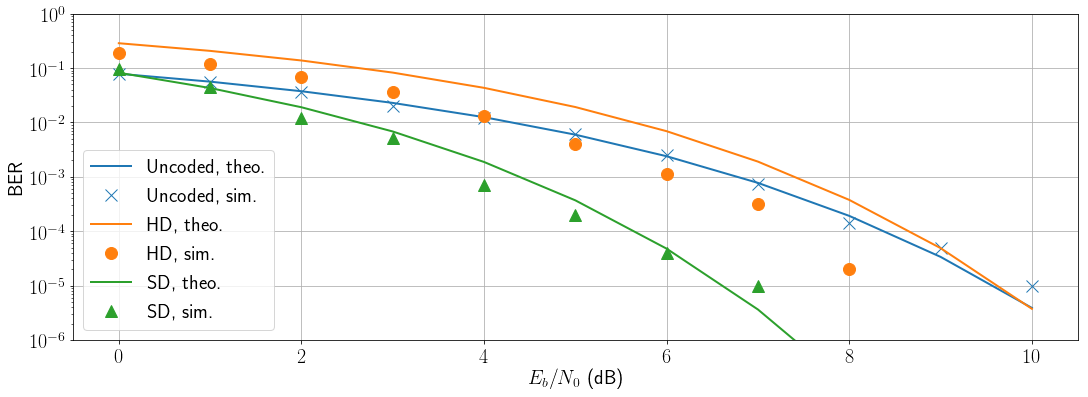

In [8]:
# theoretical ber for bpsk out of [Proakis]
ber_bpsk_theo = 1 - stats.norm.cdf( np.sqrt( 2 * EbN0_range ) )


# formula for theoretical ber out out [Friedrichs95, S. 287]
# NOTE: Since code is rate 1/n division by n gives according "code-snr"    
ber_coded_theo_hd = np.exp( - EbN0_range * C_code.d_f / C_code.n / 2)
ber_coded_theo_sd = np.exp( - EbN0_range * C_code.d_f / C_code.n )    


# plotting using identical colors for theoretical curve and simulation

# bpsk
ax_bpsk = plt.plot( EbN0_db_range, ber_bpsk_theo, linewidth=2.0, label = "Uncoded, theo.")
col_bpsk = ax_bpsk[0].get_color()  
plt.plot( EbN0_db_range, ber_bpsk, 'x', color=col_bpsk, linewidth=2.0, markersize = 12, label = "Uncoded, sim." )

# HD
ax_coded = plt.plot( EbN0_db_range, ber_coded_theo_hd, linewidth=2.0, label = "HD, theo.")        
col_coded = ax_coded[0].get_color()  
plt.plot( EbN0_db_range, ber_coded_hd, 'o', color=col_coded, markersize = 12, linewidth=2.0, label = "HD, sim.")    

# SD
ax_coded = plt.plot( EbN0_db_range, ber_coded_theo_sd, linewidth=2.0, label = "SD, theo.")        
col_coded = ax_coded[0].get_color()  
plt.plot( EbN0_db_range, ber_coded_sd, '^', color=col_coded, markersize = 12, linewidth=2.0, label = "SD, sim.")            


plt.yscale('log')
plt.grid(True)
plt.legend(loc='lower left') 

plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('BER')

plt.ylim( (1e-6, 1) )